In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import utils
import os

In [2]:
from dotenv import load_dotenv
load_dotenv()
HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")
os.environ["HOPSWORKS_API_KEY"] = HOPSWORKS_API_KEY

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
yesterday = today - datetime.timedelta(days = 1)
today

datetime.datetime(2025, 1, 23, 8, 1, 6, 706097)

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

2025-01-23 08:01:06,739 INFO: Initializing external client
2025-01-23 08:01:06,740 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-23 08:01:08,298 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207494


In [5]:
CITY = "dublin"
STATION = "HEUSTON BRIDGE (NORTH)"

STATION = STATION.replace(" ", "_")

In [6]:
feature_view = fs.get_feature_view(
    name='bike_weather_fw',
    version=1,
)

In [7]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="bike_availability_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [8]:
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
# retrieved_xgboost_model

In [9]:
weather_fg = fs.get_feature_group(
    name='weather_data',
    version=1,
)

batch_data = weather_fg.filter(weather_fg.datetime >= today).read()
batch_data["month"] = batch_data["datetime"].dt.month
batch_data["weekday"] = batch_data["datetime"].dt.weekday  # 0=Monday, 6=Sunday
batch_data["hour"] = batch_data["datetime"].dt.hour
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.71s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour
0,2025-01-26 02:00:00+00:00,0.90,-3.077816,0.0,0.0,10.883676,31026.716797,8.1,dublin,1,6,2
1,2025-01-23 19:00:00+00:00,4.70,0.533190,0.0,0.0,13.276144,30442.521484,4.2,dublin,1,3,19
2,2025-01-29 21:00:00+00:00,3.80,-1.303340,0.0,0.0,19.615870,31637.470703,0.0,dublin,1,2,21
3,2025-01-29 19:00:00+00:00,4.95,-0.425381,0.0,0.0,21.599998,31637.470703,0.0,dublin,1,2,19
4,2025-01-27 09:00:00+00:00,5.70,-0.524574,0.0,0.0,27.729347,31225.949219,0.6,dublin,1,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...
225,2025-02-01 18:00:00+00:00,7.80,4.323023,0.0,0.0,15.629971,32284.416016,5.4,dublin,2,5,18
226,2025-02-01 10:00:00+00:00,9.75,7.272669,0.7,0.0,15.175612,32284.416016,5.4,dublin,2,5,10
227,2025-02-01 21:00:00+00:00,5.70,1.981850,0.0,0.0,14.471821,32284.416016,5.4,dublin,2,5,21
228,2025-02-01 23:00:00+00:00,4.40,0.486725,0.0,0.0,14.440443,32284.416016,5.4,dublin,2,5,23


## Creating predictions

In [10]:
batch_data['predicted_bikes_available'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']]
)
batch_data['predicted_bikes_available'] = batch_data['predicted_bikes_available'].apply(lambda x: round(x))

batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available
0,2025-01-26 02:00:00+00:00,0.90,-3.077816,0.0,0.0,10.883676,31026.716797,8.1,dublin,1,6,2,32
1,2025-01-23 19:00:00+00:00,4.70,0.533190,0.0,0.0,13.276144,30442.521484,4.2,dublin,1,3,19,36
2,2025-01-29 21:00:00+00:00,3.80,-1.303340,0.0,0.0,19.615870,31637.470703,0.0,dublin,1,2,21,40
3,2025-01-29 19:00:00+00:00,4.95,-0.425381,0.0,0.0,21.599998,31637.470703,0.0,dublin,1,2,19,41
4,2025-01-27 09:00:00+00:00,5.70,-0.524574,0.0,0.0,27.729347,31225.949219,0.6,dublin,1,0,9,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,2025-02-01 18:00:00+00:00,7.80,4.323023,0.0,0.0,15.629971,32284.416016,5.4,dublin,2,5,18,24
226,2025-02-01 10:00:00+00:00,9.75,7.272669,0.7,0.0,15.175612,32284.416016,5.4,dublin,2,5,10,26
227,2025-02-01 21:00:00+00:00,5.70,1.981850,0.0,0.0,14.471821,32284.416016,5.4,dublin,2,5,21,28
228,2025-02-01 23:00:00+00:00,4.40,0.486725,0.0,0.0,14.440443,32284.416016,5.4,dublin,2,5,23,26


In [11]:
# Fill in the number of hours before the time on which you made the forecast (base_datetime)
batch_data = batch_data.sort_values(by=['datetime'])
batch_data['hours_before_forecast_time'] = range(1, len(batch_data) + 1)
batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available,hours_before_forecast_time
55,2025-01-23 10:00:00+00:00,6.60,1.337025,0.0,0.0,27.155552,30442.521484,4.2,dublin,1,3,10,11,1
21,2025-01-23 11:00:00+00:00,6.65,1.105913,0.0,0.0,28.220419,30442.521484,4.2,dublin,1,3,11,11,2
143,2025-01-23 12:00:00+00:00,6.70,0.863743,0.0,0.0,29.354902,30442.521484,4.2,dublin,1,3,12,10,3
24,2025-01-23 13:00:00+00:00,6.85,0.818373,0.0,0.0,29.940662,30442.521484,4.2,dublin,1,3,13,10,4
151,2025-01-23 14:00:00+00:00,7.05,1.002316,0.0,0.0,29.337238,30442.521484,4.2,dublin,1,3,14,10,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,2025-02-01 19:00:00+00:00,7.05,3.535300,0.0,0.0,14.843180,32284.416016,5.4,dublin,2,5,19,24,226
210,2025-02-01 20:00:00+00:00,6.35,2.731808,0.0,0.0,14.618837,32284.416016,5.4,dublin,2,5,20,29,227
227,2025-02-01 21:00:00+00:00,5.70,1.981850,0.0,0.0,14.471821,32284.416016,5.4,dublin,2,5,21,28,228
213,2025-02-01 22:00:00+00:00,5.00,1.166210,0.0,0.0,14.404499,32284.416016,5.4,dublin,2,5,22,26,229


## Create forecast graph

2025-01-23 08:01:17,617 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



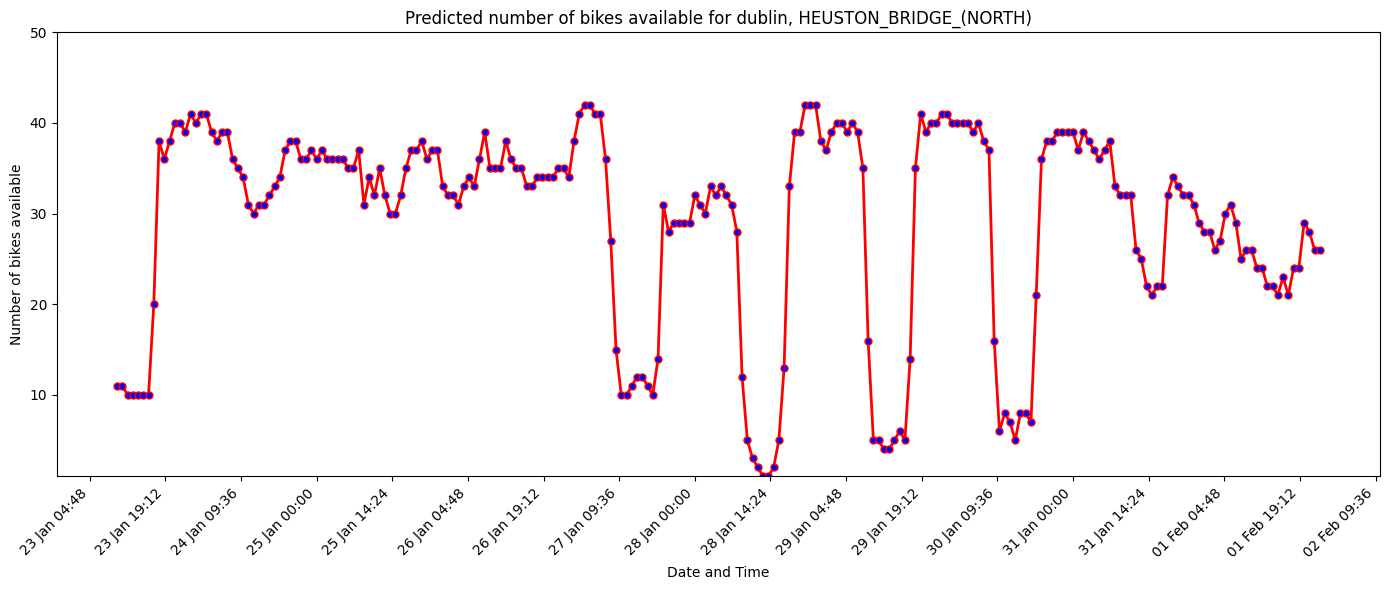

In [12]:
file_path = "docs/bike_availability_forecast.png"
plt = utils.plot_bike_availability_forecast(CITY, STATION, batch_data, file_path)
plt.show()

In [13]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='bike_availability_predictions',
    description='Bike availability prediction monitoring for ' + STATION.replace("_", " "),
    version=1,
    primary_key=["datetime", "city"],
    event_time="datetime"
)

In [14]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 100.00% |██████████| Rows 230/230 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: bike_availability_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1207494/jobs/named/bike_availability_predictions_1_offline_fg_materialization/executions
2025-01-23 08:01:32,929 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-01-23 08:01:36,120 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-01-23 08:03:33,804 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-01-23 08:03:33,960 INFO: Waiting for log aggregation to finish.
2025-01-23 08:04:09,298 INFO: Execution finished successfully.


(Job('bike_availability_predictions_1_offline_fg_materialization', 'SPARK'),
 None)

In [15]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.hours_before_forecast_time <= 24).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.35s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available,hours_before_forecast_time
0,2025-01-24 03:00:00+00:00,11.300000,5.056276,1.9,0.0,41.104683,30634.960938,7.5,dublin,1,4,3,41,18
1,2025-01-23 01:00:00+00:00,4.650000,1.574594,0.0,0.0,11.019764,30442.521484,2.9,dublin,1,3,1,39,15
2,2025-01-22 06:00:00+00:00,2.250000,-0.657853,0.0,0.0,7.754637,30252.697266,3.3,dublin,1,2,6,37,18
3,2025-01-22 05:00:00+00:00,2.100000,-0.883082,0.0,0.0,8.089993,30252.697266,3.3,dublin,1,2,5,36,17
4,2025-01-24 04:00:00+00:00,10.850000,2.866684,0.0,0.0,49.130436,30634.960938,7.5,dublin,1,4,4,39,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,2024-12-28 06:00:00+00:00,8.689500,6.399599,0.0,0.0,11.931705,27194.826172,0.0,dublin,12,5,6,40,6
89,2024-12-28 08:00:00+00:00,8.639501,6.310997,0.0,0.0,12.456468,27194.826172,0.0,dublin,12,5,8,40,8
90,2024-12-29 00:00:00+00:00,7.939500,5.065456,0.0,0.0,13.619471,27249.105469,0.0,dublin,12,6,0,35,24
91,2024-12-28 17:00:00+00:00,8.789500,5.991804,0.0,0.0,15.070633,27194.826172,0.0,dublin,12,5,17,31,17


In [16]:
bike_fg = fs.get_feature_group(
    name='bike_data',
    version=1,
)
bike_df = bike_fg.read()

bike_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.93s) 


,datetime,station,num_bikes_available
0,2024-09-23 10:00:00+00:00,HEUSTON_BRIDGE_(NORTH),2.0
1,2023-10-07 13:00:00+00:00,HEUSTON_BRIDGE_(NORTH),29.0
2,2023-11-27 07:00:00+00:00,HEUSTON_BRIDGE_(NORTH),34.0
3,2024-01-22 22:00:00+00:00,HEUSTON_BRIDGE_(NORTH),35.0
4,2023-10-16 02:00:00+00:00,HEUSTON_BRIDGE_(NORTH),40.0
...,...,...,...
9617,2025-01-22 16:00:00+00:00,HEUSTON_BRIDGE_(NORTH),5.0
9618,2025-01-22 04:00:00+00:00,HEUSTON_BRIDGE_(NORTH),40.0
9619,2025-01-22 14:00:00+00:00,HEUSTON_BRIDGE_(NORTH),1.0
9620,2025-01-23 00:00:00+00:00,HEUSTON_BRIDGE_(NORTH),40.0


In [17]:
weather_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city
0,2024-11-17 07:00:00+00:00,6.6395,3.542508,0.0,0.0,13.091829,30647.093750,2.6,dublin
1,2024-07-26 02:00:00+00:00,12.0395,9.959105,0.0,0.0,15.349684,57427.019531,0.9,dublin
2,2024-08-02 09:00:00+00:00,18.9895,18.108223,0.0,0.0,19.469975,56053.718750,2.5,dublin
3,2024-03-28 18:00:00+00:00,8.1395,6.004910,0.1,0.0,4.334974,46005.636719,1.3,dublin
4,2024-01-09 08:00:00+00:00,3.7895,-1.855704,0.0,0.0,21.602999,28177.490234,0.0,dublin
...,...,...,...,...,...,...,...,...,...
12739,2025-02-01 18:00:00+00:00,7.8000,4.323023,0.0,0.0,15.629971,32284.416016,5.4,dublin
12740,2025-02-01 10:00:00+00:00,9.7500,7.272669,0.7,0.0,15.175612,32284.416016,5.4,dublin
12741,2025-02-01 21:00:00+00:00,5.7000,1.981850,0.0,0.0,14.471821,32284.416016,5.4,dublin
12742,2025-02-01 23:00:00+00:00,4.4000,0.486725,0.0,0.0,14.440443,32284.416016,5.4,dublin


In [18]:
def backfill_predictions_for_monitoring(weather_fg, bike_df, monitor_fg, model):
    features_df = weather_fg.read()

    features_df["month"] = features_df["datetime"].dt.month
    features_df["weekday"] = features_df["datetime"].dt.weekday  # 0=Monday, 6=Sunday
    features_df["hour"] = features_df["datetime"].dt.hour

    features_df = pd.merge(features_df, bike_df[['datetime','num_bikes_available']], on="datetime")
    features_df = features_df.sort_values(by=['datetime'], ascending=True)
    features_df = features_df.tail(10*24)
    
    features_df['predicted_bikes_available'] = model.predict(features_df[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']])
    features_df['predicted_bikes_available'] = features_df['predicted_bikes_available'].apply(lambda x: round(x))

    features_df['hours_before_forecast_time'] = range(1, len(features_df) + 1)
    hindcast_df = features_df
    features_df = features_df.drop('num_bikes_available', axis=1)
    monitor_fg.insert(features_df, write_options={"wait_for_job": True})
    return hindcast_df

In [19]:
outcome_df = bike_df[['datetime', 'num_bikes_available']]
preds_df =  monitoring_df[['datetime', 'predicted_bikes_available']]

hindcast_df = pd.merge(preds_df, outcome_df, on="datetime")
hindcast_df = hindcast_df.sort_values(by=['datetime'])
print(len(hindcast_df))
hindcast_df

60


,datetime,predicted_bikes_available,num_bikes_available
59,2024-12-28 01:00:00+00:00,39,39.0
42,2024-12-28 02:00:00+00:00,40,39.0
52,2024-12-28 03:00:00+00:00,40,39.0
36,2024-12-28 04:00:00+00:00,39,39.0
44,2024-12-28 05:00:00+00:00,38,39.0
55,2024-12-28 06:00:00+00:00,40,39.0
37,2024-12-28 07:00:00+00:00,39,39.0
56,2024-12-28 08:00:00+00:00,40,39.0
50,2024-12-28 09:00:00+00:00,41,38.0
43,2024-12-28 10:00:00+00:00,38,37.0


In [20]:
outcome_df = outcome_df.sort_values(by=['datetime'])
outcome_df

,datetime,num_bikes_available
5695,2023-08-07 02:00:00+00:00,10.0
2161,2023-08-07 03:00:00+00:00,10.0
3422,2023-08-07 04:00:00+00:00,10.0
8312,2023-08-07 05:00:00+00:00,10.0
2192,2023-08-07 06:00:00+00:00,10.0
...,...,...
9605,2025-01-22 20:00:00+00:00,40.0
9601,2025-01-22 21:00:00+00:00,39.0
9599,2025-01-22 22:00:00+00:00,39.0
9621,2025-01-22 23:00:00+00:00,40.0


In [21]:
preds_df = preds_df.sort_values(by=['datetime'])
preds_df

,datetime,predicted_bikes_available
92,2024-12-28 01:00:00+00:00,39
75,2024-12-28 02:00:00+00:00,40
85,2024-12-28 03:00:00+00:00,40
69,2024-12-28 04:00:00+00:00,39
77,2024-12-28 05:00:00+00:00,38
...,...,...
66,2025-01-24 05:00:00+00:00,38
29,2025-01-24 06:00:00+00:00,39
27,2025-01-24 07:00:00+00:00,39
17,2025-01-24 08:00:00+00:00,36


In [22]:

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
print("Hindcast length: ", len(hindcast_df))
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring(weather_fg, bike_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Hindcast length:  60


,datetime,predicted_bikes_available,num_bikes_available
59,2024-12-28 01:00:00+00:00,39,39.0
42,2024-12-28 02:00:00+00:00,40,39.0
52,2024-12-28 03:00:00+00:00,40,39.0
36,2024-12-28 04:00:00+00:00,39,39.0
44,2024-12-28 05:00:00+00:00,38,39.0
55,2024-12-28 06:00:00+00:00,40,39.0
37,2024-12-28 07:00:00+00:00,39,39.0
56,2024-12-28 08:00:00+00:00,40,39.0
50,2024-12-28 09:00:00+00:00,41,38.0
43,2024-12-28 10:00:00+00:00,38,37.0


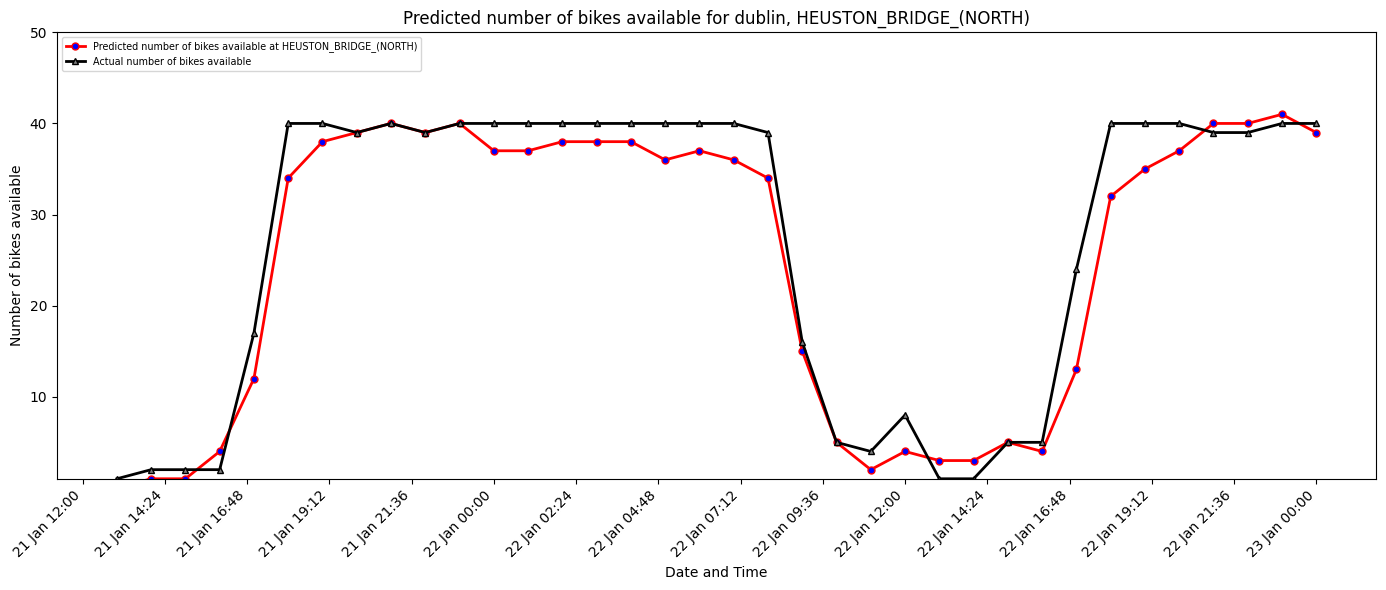

In [24]:
file_path = "docs/bike_availability_hindcast_10days.png"
import pytz

today = datetime.datetime.now(pytz.utc)
hindcast_df_10days = hindcast_df[hindcast_df['datetime'] >= today - datetime.timedelta(days=10)]

plt = utils.plot_bike_availability_forecast(CITY, STATION, hindcast_df_10days, file_path, hindcast=True)
plt.show()